# VT Landscape

**Objective**: Comparative analysis across regions on VT ratio to see if there's any difference between offices and target countires in terms of VT install rate.

**Scope** (this notebook):
- VT install ratio at a campaign level
- across offices + top target countires

**Out of scope** :
- //

**Key Tables**:
- //


---
Ref: 

In [8]:
#@title Environment Setup

from google.cloud import bigquery

import os
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


client = bigquery.Client(project='moloco-ods')

def process_query(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    df_return = query_job.result().to_dataframe()
    return df_return

def process_query_be(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    print(f"Submitted job: {query_job.job_id}")
    return query_job

def fetch_result(query_job):
    try:
        if query_job.done():
            if query_job.error_result:
                print(f"Job {query_job.job_id} failed: {query_job.error_result}")
                return {"status": "error", "job_id": query_job.job_id, "error": query_job.error_result}
            else:
                print(f"Job {query_job.job_id} is complete!")
                df_return = query_job.result().to_dataframe()
                return {"status": "success", "job_id": query_job.job_id, "data": df_return}
        else:
            print(f"Job {query_job.job_id} is still running...")
            return None
    except Exception as e:
        print(f"Job {query_job.job_id} raised an exception: {e}")
        return {"status": "exception", "job_id": query_job.job_id, "error": str(e)}

In [ ]:
#@title Top 10 countries by spend

top_countries_query = """
    SELECT
        campaign.country,
        SUM(gross_spend_usd) AS total_spend
    FROM `moloco-ae-view.athena.fact_dsp_core`
    WHERE
        date_utc BETWEEN '2026-01-01' AND '2026-01-31'
        AND advertiser.office IN ('KOR', 'JPN','USA','EMEA','SGP','CHN','IND')
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
"""

df_top_countries = process_query(top_countries_query)
top_countries = df_top_countries['country'].tolist()
top_countries_str = ", ".join(f"'{c}'" for c in top_countries)

print(f"Top 10 countries by spend: {top_countries}")
print(f"SQL filter: ({top_countries_str})")

## Step 1. VT ratio by office and target countries as a whole

In [9]:
vt_query = f"""
    SELECT
        advertiser.office,
        campaign.country,
        SUM(installs_vt) AS installs_vt, 
        SUM(installs) AS installs,
        SAFE_DIVIDE(SUM(installs_vt), SUM(installs)) as vt_ratio
    FROM `moloco-ae-view.athena.fact_dsp_core`
    WHERE 
        date_utc BETWEEN '2026-01-01' AND '2026-01-31'        
        AND advertiser.office IN ('KOR', 'JPN','USA','EMEA','SGP','CHN','IND')
        AND campaign.country IN ({top_countries_str})
    GROUP BY 1, 2

"""

df_vt = process_query(vt_query)

df_vt.head()

,office,country,installs_vt,installs,vt_ratio
0,EMEA,KOR,4860,157291,0.030898
1,JPN,KOR,13966,23477,0.594880
2,KOR,USA,77001,311762,0.246986
3,IND,AUS,1244,4309,0.288698
4,IND,CAN,1348,3338,0.403835


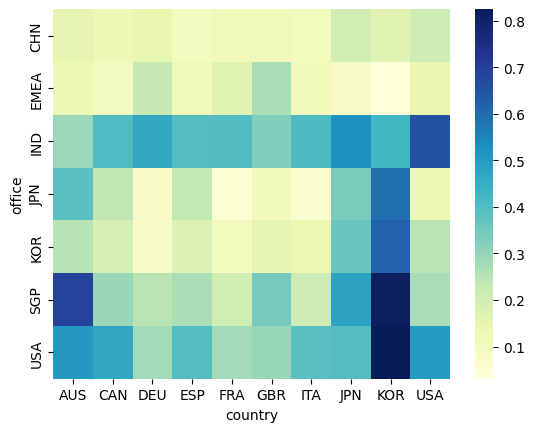

In [10]:
# draw a heatmap by vt_ratio
sns.heatmap(df_vt.pivot(index='office', columns='country', values='vt_ratio'), cmap='YlGnBu')
plt.show()

## Step 2-1. VT ratio at bundle level

In [11]:
vt_query_bundle = f"""
    SELECT
        advertiser.office,
        campaign.country,
        product.app_market_bundle,
        SUM(installs_vt) AS installs_vt, 
        SUM(installs) AS installs,
        SAFE_DIVIDE(SUM(installs_vt), SUM(installs)) as vt_ratio
    FROM `moloco-ae-view.athena.fact_dsp_core`
    WHERE 
        date_utc BETWEEN '2026-01-01' AND '2026-01-31'        
        AND advertiser.office IN ('KOR', 'JPN','USA','EMEA','SGP','CHN','IND')
        AND campaign.country IN ({top_countries_str})
    GROUP BY 1, 2, 3

"""

df_vt_bundle = process_query(vt_query_bundle)

df_vt_bundle.head()


,office,country,app_market_bundle,installs_vt,installs,vt_ratio
0,CHN,AUS,6472251806,0,0,NaN
1,KOR,AUS,6737821799,19,23,0.826087
2,EMEA,AUS,6744527742,122,572,0.213287
3,EMEA,AUS,1105855019,0,0,NaN
4,EMEA,AUS,com.chickchickblast.app,1,111,0.009009


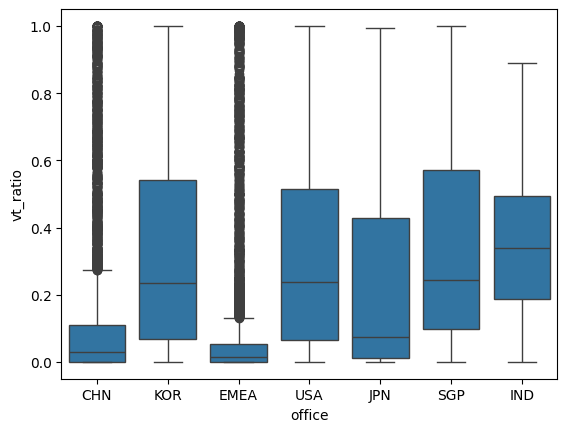

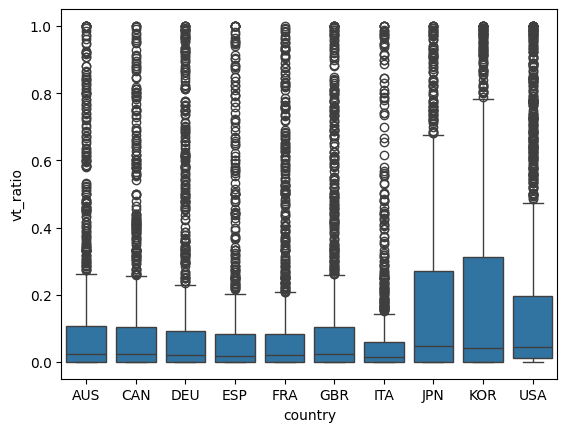

In [12]:
#draw distribution of vt_ratio by office and target country
sns.boxplot(x='office', y='vt_ratio', data=df_vt_bundle)
plt.show()

#draw distribution of vt_ratio by office and target country
sns.boxplot(x='country', y='vt_ratio', data=df_vt_bundle)
plt.show()

## Step 2-2. VT ratio at campaign level

In [13]:
vt_query = f"""
    SELECT
        advertiser.office,
        campaign.country,
        campaign_id,
        SUM(installs_vt) AS installs_vt, 
        SUM(installs) AS installs,
        SAFE_DIVIDE(SUM(installs_vt), SUM(installs)) as vt_ratio
    FROM `moloco-ae-view.athena.fact_dsp_core`
    WHERE 
        date_utc BETWEEN '2026-01-01' AND '2026-01-31'        
        AND advertiser.office IN ('KOR', 'JPN','USA','EMEA','SGP','CHN','IND')
        AND campaign.country IN ({top_countries_str})
    GROUP BY 1, 2, 3

"""

df_vt_campaign = process_query(vt_query)

df_vt_campaign.head()

,office,country,campaign_id,installs_vt,installs,vt_ratio
0,CHN,AUS,sgzlwwhwDZ39Xskp,11,977,0.011259
1,CHN,ITA,sgzlwwhwDZ39Xskp,12,771,0.015564
2,CHN,JPN,x7DETrCyDEbwhMdJ,59,8608,0.006854
3,CHN,GBR,GprbznCUiBYw6xLb,41,3680,0.011141
4,CHN,GBR,FQM8qG2yuQ4lFPex,20,469,0.042644


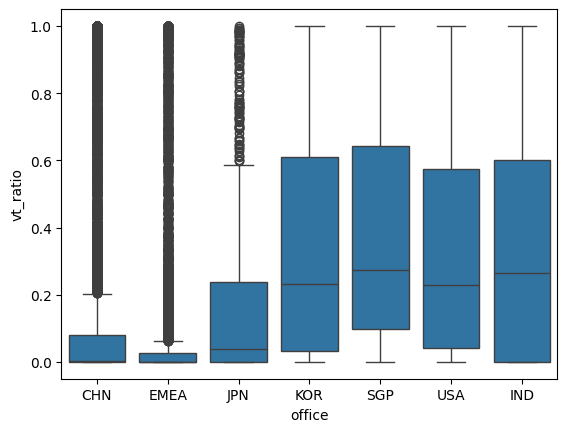

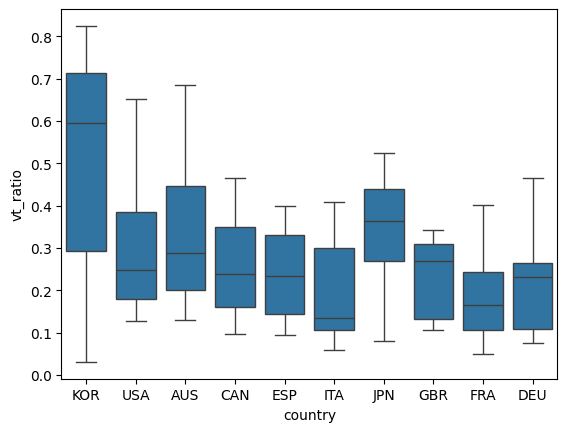

In [14]:
#@title VT ratio distribution by office and target 


# draw box plot by office
sns.boxplot(x='office', y='vt_ratio', data=df_vt_campaign)
plt.show()

# draw box plot by target country
sns.boxplot(x='country', y='vt_ratio', data=df_vt)
plt.show()

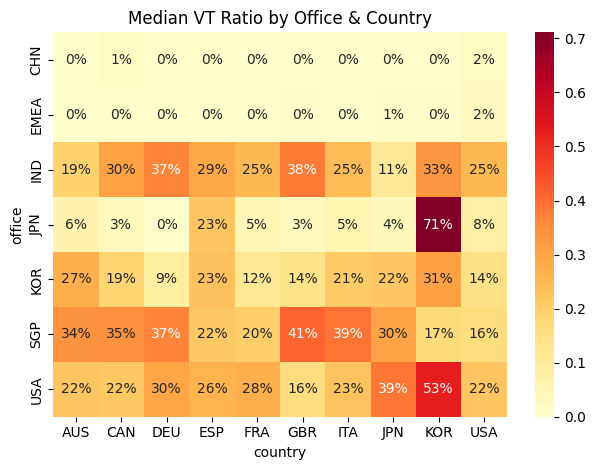

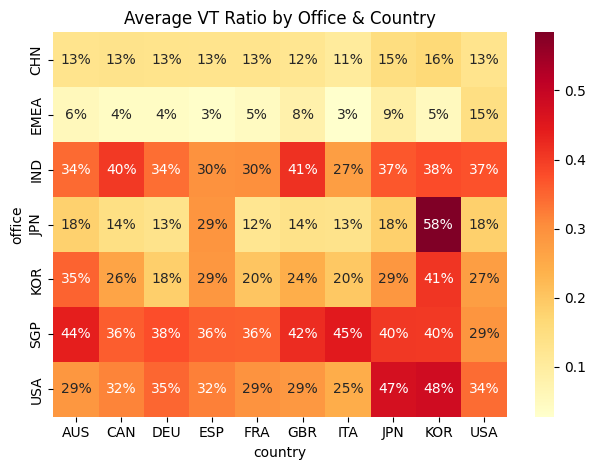

In [15]:
# draw a heatmap by vt_ratio with median value of vt_ratio

pivot_median = df_vt_campaign.pivot_table(index='office', columns='country', values='vt_ratio', aggfunc='median')

# please make the format with percentage
sns.heatmap(pivot_median, annot=True, fmt='.0%', cmap='YlOrRd')
plt.title('Median VT Ratio by Office & Country')
plt.tight_layout()
plt.show()

pivot_avg = df_vt_campaign.pivot_table(index='office', columns='country', values='vt_ratio', aggfunc='mean')

# please make the format with percentage
sns.heatmap(pivot_avg, annot=True, fmt='.0%', cmap='YlOrRd')
plt.title('Average VT Ratio by Office & Country')
plt.tight_layout()
plt.show()

## VT ratio by cr format mix

In [16]:
query_cr_mix = f"""
    SELECT
        advertiser.office,
        campaign.country,
        campaign_id,
        SUM(if(creative.format = 'ib', installs_vt, 0)) as installs_vt_ib,
        SUM(if(creative.format = 'ib', installs, 0)) as installs_ib,
        SAFE_DIVIDE(SUM(if(creative.format = 'ib', installs_vt, 0)), SUM(if(creative.format = 'ib', installs, 0))) as vt_ratio_ib,
        SUM(if(creative.format IN ('vi', 'ri', 'nv'), installs_vt, 0)) as installs_vt_rich,
        SUM(if(creative.format IN ('vi', 'ri', 'nv'), installs, 0)) as installs_rich,
        SAFE_DIVIDE(SUM(if(creative.format IN ('vi', 'ri', 'nv'), installs_vt, 0)), SUM(if(creative.format IN ('vi', 'ri', 'nv'), installs, 0))) as vt_ratio_rich,
        SUM(installs_vt) AS installs_vt, 
        SUM(installs) AS installs,
        SAFE_DIVIDE(SUM(installs_vt), SUM(installs)) as vt_ratio
    FROM `moloco-ae-view.athena.fact_dsp_creative`
    WHERE
        date_utc BETWEEN '2026-01-01' AND '2026-01-31'
        AND advertiser.office IN ('KOR', 'JPN','USA','EMEA','SGP','CHN','IND')
        AND campaign.country IN ({top_countries_str})
    GROUP BY 1, 2, 3

"""

df_cr_mix = process_query(query_cr_mix)

df_cr_mix.head()


,office,country,campaign_id,installs_vt_ib,installs_ib,vt_ratio_ib,installs_vt_rich,installs_rich,vt_ratio_rich,installs_vt,installs,vt_ratio
0,CHN,KOR,tpMReivrX92DEhXT,23,28,0.821429,53,9656,0.005489,82,9699,0.008454
1,CHN,GBR,zFT7W9eezSfPxYoV,72,98,0.734694,22,5458,0.004031,112,5615,0.019947
2,CHN,KOR,ip5229jN4fhmWi4a,0,0,NaN,89,263,0.338403,15479,16123,0.960057
3,EMEA,CAN,ux9VVTJaetoYMITv,0,0,NaN,13,145,0.089655,13,146,0.089041
4,EMEA,FRA,fq75Kkj3TjxLss5x,0,0,NaN,6,191,0.031414,6,191,0.031414


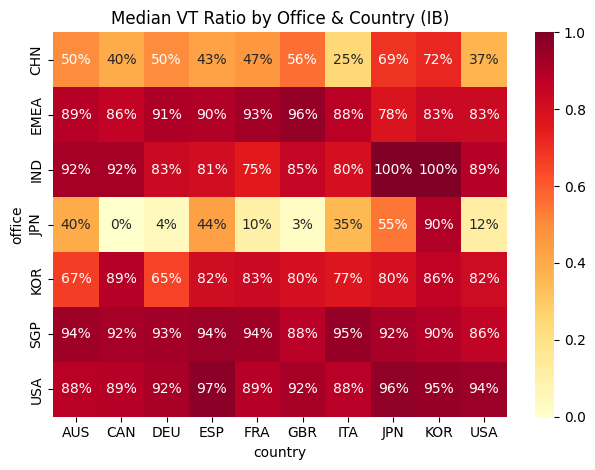

Text(0.5, 1.0, 'Median VT Ratio by Office & Country (Rich formats: vi/ri/nv)')

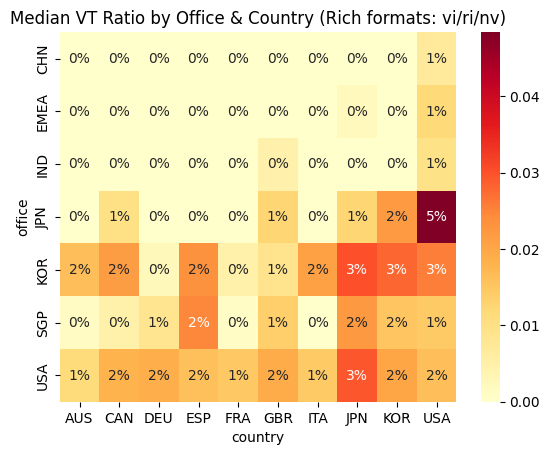

In [17]:
# draw a heatmap by vt_ratio_ib and vt_ratio_rich

pivot_median_ib = df_cr_mix.pivot_table(index='office', columns='country', values='vt_ratio_ib', aggfunc='median')
pivot_median_rich = df_cr_mix.pivot_table(index='office', columns='country', values='vt_ratio_rich', aggfunc='median')

sns.heatmap(pivot_median_ib, annot=True, fmt='.0%', cmap='YlOrRd')
plt.title('Median VT Ratio by Office & Country (IB)')
plt.tight_layout()
plt.show()

sns.heatmap(pivot_median_rich, annot=True, fmt='.0%', cmap='YlOrRd')
plt.title('Median VT Ratio by Office & Country (Rich formats: vi/ri/nv)')

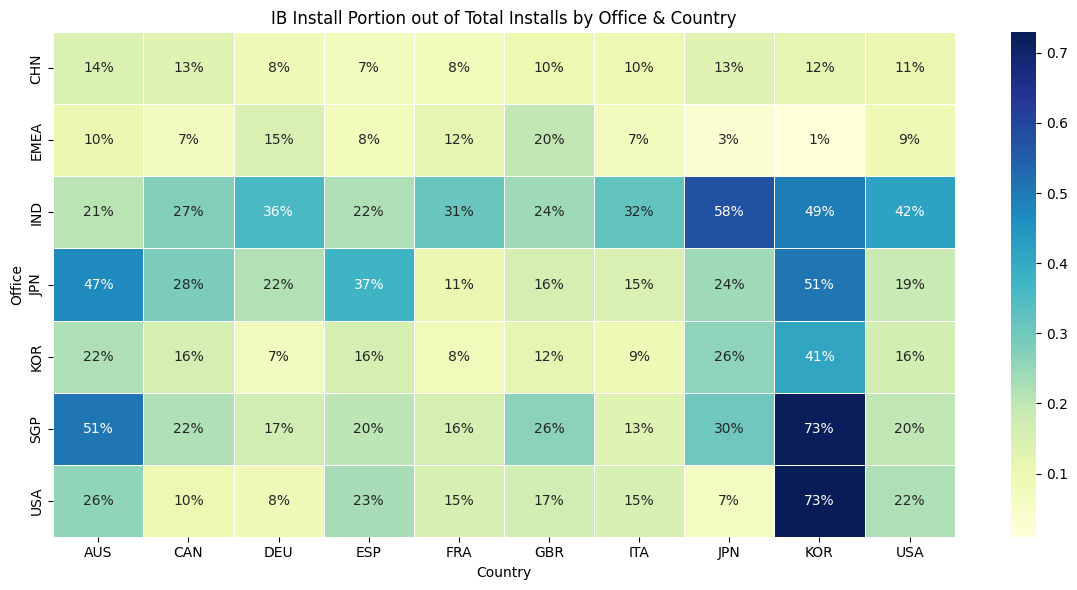

In [18]:
# ib install portion out of total installs across offices and target countries (not about VT ratio)

df_ib_portion = (
    df_cr_mix
    .groupby(['office', 'country'])
    .agg(installs_ib=('installs_ib', 'sum'), installs=('installs', 'sum'))
    .assign(ib_install_ratio=lambda x: x['installs_ib'] / x['installs'])
    .reset_index()
)

pivot_ib_portion = df_ib_portion.pivot_table(
    index='office', columns='country', values='ib_install_ratio', aggfunc='mean'
).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_ib_portion, annot=True, fmt='.0%', cmap='YlGnBu', linewidths=0.5, mask=pivot_ib_portion.isna())
plt.title('IB Install Portion out of Total Installs by Office & Country')
plt.ylabel('Office')
plt.xlabel('Country')
plt.tight_layout()
plt.show()
